# Kalman Filter

This example optimizes the parameters of a [Kalman-Filter](https://en.wikipedia.org/wiki/Kalman_filter).

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/kalman_filter.ipynb).

In [1]:
import functools as ft
from types import SimpleNamespace
from typing import Optional

import diffrax as dfx
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

We use [Equinox](https://github.com/patrick-kidger/equinox) to build the Kalman-Filter implementation and to represent linear, time-invariant systems (LTI systems). 

We use [Optax](https://github.com/deepmind/optax) for optimisers (Adam etc.)

## Problem Formulation

Assume that there exists some *unknown* dynamical system of the form

$\frac{dx}{dt}(t)= f(x(t), u(t), t)$

$y(t) = g(x(t)) + \epsilon(t)$ 

where 
- $u(t)$ denotes the time-dependent input to the system
- $y(t)$ denotes the time-dependent output / measurement to the system
- $x(t)$ denotes the time-dependent state of the system (which is not directly measureable in general)
- $f,g$ denote the time-dependent dynamics- and measurement-function, respectively
- $\epsilon$ denotes random measurement uncertainty

*The goal is to infer $x$ from $y$ even though $f,g,\epsilon$ are unkown.*

*A Kalman-Filter represents a possible solution.*


!!! info

    From [Wikipedia](https://en.wikipedia.org/wiki/Kalman_filter): 
    
    Kalman filtering, also known as linear quadratic estimation (LQE), is an algorithm that uses a series of measurements observed over time, including statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe. The filter is named after Rudolf E. Kálmán, who was one of the primary developers of its theory.

    The algorithm works by a two-phase process. For the prediction phase, the Kalman filter produces estimates of the current state variables, along with their uncertainties. Once the outcome of the next measurement (necessarily corrupted with some error, including random noise) is observed, these estimates are updated using a weighted average, with more weight being given to estimates with greater certainty. The algorithm is recursive. It can operate in real time, using only the present input measurements and the state calculated previously and its uncertainty matrix; no additional past information is required.
    

For the sake of simplicity, here we assume that the dynamical system takes the form

$\frac{dx}{dt} = Ax(t) + Bu(t)$

$y(t) = Cx(t) + \epsilon$ 

where $A,B,C$ are constant matrices, i.e. the system is linear in its state $x(t)$ and its input $u(t)$. Further, the dynamics- and measurement-functions do not depend on time.

Hence, the above represents the general form of (physical) *linear, time-invariant systems* (LTI systems).

Here we define a container object for LTI systems.

In [2]:
class LTISystem(eqx.Module):
    A: jnp.ndarray
    B: jnp.ndarray
    C: jnp.ndarray

An harmonic oscillator is an LTI system, this function returns such an LTI system.

In [3]:
def harmonic_oscillator(damping: float = 0.0, time_scaling: float = 1.0) -> LTISystem:
    A = jnp.array([[0.0, time_scaling], [-time_scaling, -2 * damping]])
    B = jnp.array([[0.0], [1.0]])
    C = jnp.array([[0.0, 1.0]])
    return LTISystem(A, B, C)

Here we define some utility functions that allow us to simulate LTI systems.

In [4]:
def interpolate_us(ts, us, B):
    if us is None:
        m = B.shape[-1]
        u_t = SimpleNamespace(evaluate=lambda t: jnp.zeros((m,)))
    else:
        u_t = dfx.LinearInterpolation(ts=ts, ys=us)
    return u_t


def diffeqsolve(
    rhs,
    ts: jnp.ndarray,
    y0: jnp.ndarray,
    solver: dfx.AbstractSolver = dfx.Dopri5(),
    stepsize_controller: dfx.AbstractStepSizeController = dfx.ConstantStepSize(),
    dt0: float = 0.01,
) -> jnp.ndarray:
    return dfx.diffeqsolve(
        dfx.ODETerm(rhs),
        solver=solver,
        stepsize_controller=stepsize_controller,
        t0=ts[0],
        t1=ts[-1],
        y0=y0,
        dt0=dt0,
        saveat=dfx.SaveAt(ts=ts),
    ).ys


def simulate_lti_system(
    sys: LTISystem,
    y0: jnp.ndarray,
    ts: jnp.ndarray,
    us: Optional[jnp.ndarray] = None,
    std_measurement_noise: float = 0.0,
    key=jr.PRNGKey(
        1,
    ),
):
    u_t = interpolate_us(ts, us, sys.B)

    def rhs(t, y, args):
        return sys.A @ y + sys.B @ u_t.evaluate(t)

    xs = diffeqsolve(rhs, ts, y0)
    # noisy measurements
    ys = xs @ sys.C.transpose()
    ys = ys + jr.normal(key, shape=ys.shape) * std_measurement_noise
    return xs, ys

Here we define the Kalman-Filter.

Note how we use `equinox` to combine the Kalman-Filter logic in `__call__` and the Kalman-Filter parameters `Q` , `R` in one object.

In [12]:
class KalmanFilter(eqx.Module):
    """Continuous-time Kalman Filter

    Ref:
        [1] Optimal and robust estimation. 2nd edition. Page 154.
        https://lewisgroup.uta.edu/ee5322/lectures/CTKalmanFilterNew.pdf
    """

    sys: LTISystem
    x0: jnp.ndarray
    P0: jnp.ndarray
    Q: jnp.ndarray
    R: jnp.ndarray

    def __call__(self, ts, ys, us: Optional[jnp.ndarray] = None):

        A, B, C = self.sys.A, self.sys.B, self.sys.C

        y_t = dfx.LinearInterpolation(ts=ts, ys=ys)
        u_t = interpolate_us(ts, us, B)

        y0 = (self.x0, self.P0)

        def rhs(t, y, args):
            x, P = y

            # eq 3.22 of Ref [1]
            K = P @ C.transpose() @ jnp.linalg.inv(self.R)

            # eq 3.21 of Ref [1]
            dPdt = (
                A @ P
                + P @ A.transpose()
                + self.Q
                - P @ C.transpose() @ jnp.linalg.inv(self.R) @ C @ P
            )

            # eq 3.23 of Ref [1]
            dxdt = A @ x + B @ u_t.evaluate(t) + K @ (y_t.evaluate(t) - C @ x)

            return (dxdt, dPdt)

        return diffeqsolve(rhs, ts, y0)[0]

Main entry point. Try runnning `main()`.

In [13]:
def main(
    # evaluate at these timepoints
    ts=jnp.arange(0, 5.0, 0.01),
    # system that generates data
    sys_true=harmonic_oscillator(0.3),
    # initial state of our data generating system
    sys_true_x0=jnp.array([1.0, 0.0]),
    # standard deviation of measurement noise
    sys_true_std_measurement_noise=1.0,
    # our model for system `true`, it's not perfect
    sys_model=harmonic_oscillator(0.7),
    # initial state guess, it's not perfect
    sys_model_x0=jnp.array([0.0, 0.0]),
    # weighs how much we trust our model of the system
    Q=jnp.diag(jnp.ones((2,))) * 0.1,
    # weighs how much we trust in the measurements of the system
    R=jnp.diag(jnp.ones((1,))),
    # weighs how much we trust our initial guess
    P0=jnp.diag(jnp.ones((2,))) * 10.0,
    plot=True,
    n_gradient_steps=0,
    print_every=10,
):

    xs, ys = simulate_lti_system(
        sys_true, sys_true_x0, ts, std_measurement_noise=sys_true_std_measurement_noise
    )

    kmf = KalmanFilter(sys_model, sys_model_x0, P0, Q, R)

    print(f"Initial Q: \n{kmf.Q}\n Initial R: \n{kmf.R}")

    # gradients should only be able to change Q/R parameters
    # *not* the model (well at least not in this example :)
    filter_spec = jtu.tree_map(lambda arr: False, kmf)
    filter_spec = eqx.tree_at(
        lambda tree: (tree.Q, tree.R), filter_spec, replace=(True, True)
    )

    @eqx.filter_jit
    @ft.partial(eqx.filter_value_and_grad, arg=filter_spec)
    def loss_fn(kmf, ts, ys, xs):
        xhats = kmf(ts, ys)
        return jnp.mean((xs - xhats) ** 2)

    opt = optax.adam(1e-2)
    opt_state = opt.init(kmf)

    for step in range(n_gradient_steps):
        value, grads = loss_fn(kmf, ts, ys, xs)
        if step % print_every == 0:
            print("Current MSE: ", value)
        updates, opt_state = opt.update(grads, opt_state)
        kmf = eqx.apply_updates(kmf, updates)

    print(f"Final Q: \n{kmf.Q}\n Final R: \n{kmf.R}")

    if plot:
        xhats = kmf(ts, ys)
        plt.plot(ts, xs[:, 0], label="true position", color="orange")
        plt.plot(
            ts,
            xhats[:, 0],
            label="estimated position",
            color="orange",
            linestyle="dashed",
        )
        plt.plot(ts, xs[:, 1], label="true velocity", color="blue")
        plt.plot(
            ts,
            xhats[:, 1],
            label="estimated velocity",
            color="blue",
            linestyle="dashed",
        )
        plt.xlabel("time")
        plt.ylabel("position / velocity")
        plt.legend()
        plt.title("KalmanFilter optimization w.r.t Q/R")

Initial Q: 
[[0.1 0. ]
 [0.  0.1]]
 Initial R: 
[[1.]]
Final Q: 
[[0.1 0. ]
 [0.  0.1]]
 Final R: 
[[1.]]


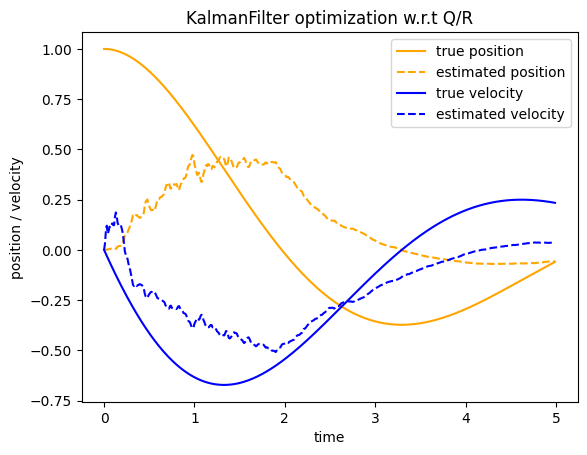

In [14]:
main(n_gradient_steps=0)

Initial Q: 
[[0.1 0. ]
 [0.  0.1]]
 Initial R: 
[[1.]]
Current MSE:  0.10257154
Current MSE:  0.09800266
Current MSE:  0.09304534
Current MSE:  0.087538235
Current MSE:  0.08122826
Current MSE:  0.07371251
Current MSE:  0.06441843
Current MSE:  0.05347546
Current MSE:  0.046111725
Current MSE:  0.03786327
Final Q: 
[[-0.44275677  1.3142775 ]
 [-1.1867669   0.9120258 ]]
 Final R: 
[[0.14836916]]


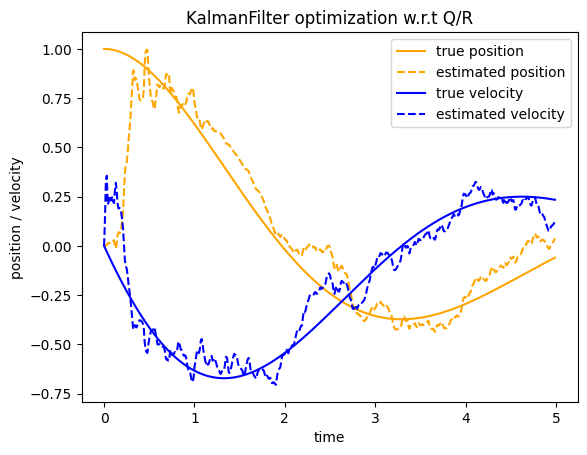

In [15]:
main(n_gradient_steps=100)

We can see that the MSE is smaller after optimization. 

After optimization we trust the measurements more as there is a significant modeling error.

We can observe this nicely through the added noise in our state estimate. Recall that the measurements are noisy after all.